# Classification

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import (
    f1_score,
    average_precision_score,
    classification_report,
    precision_recall_curve,
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

RANDOM_STATE = 42


**Hotel Reservations**
Задача: по информации о бронировании (тип номера, канал, срок до заезда, история клиента, цена и т.д.) предсказать, будет ли бронь отменена.

Практический смысл: помочь отелю уменьшить потери от отмен, лучше планировать загрузку номеров и доход.

Метрики: F1, PR-AUC по классу `Canceled`.

Data Dictionary

- Booking_ID: unique identifier of each booking
- no_of_adults: Number of adults
- no_of_children: Number of Children
- no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- type_of_meal_plan: Type of meal plan booked by the customer:
- required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
- room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
- lead_time: Number of days between the date of booking and the arrival date
- arrival_year: Year of arrival date
- arrival_month: Month of arrival date
- arrival_date: Date of the month
- market_segment_type: Market segment designation.
- repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
- no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
- no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
- avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
- no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
- booking_status: Flag indicating if the booking was canceled or not.

In [2]:
df = pd.read_csv("data/classification/Hotel_Reservations.csv")
df.shape

(36275, 19)

In [3]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [4]:
# Баланс классов:
print(df["booking_status"].value_counts())
print(df["booking_status"].value_counts(normalize=True).round(2))

booking_status
Not_Canceled    24390
Canceled        11885
Name: count, dtype: int64
booking_status
Not_Canceled    0.67
Canceled        0.33
Name: proportion, dtype: float64


In [5]:
# пропуски
df.isna().mean().sort_values(ascending=False)

Booking_ID                              0.0
arrival_month                           0.0
no_of_special_requests                  0.0
avg_price_per_room                      0.0
no_of_previous_bookings_not_canceled    0.0
no_of_previous_cancellations            0.0
repeated_guest                          0.0
market_segment_type                     0.0
arrival_date                            0.0
arrival_year                            0.0
no_of_adults                            0.0
lead_time                               0.0
room_type_reserved                      0.0
required_car_parking_space              0.0
type_of_meal_plan                       0.0
no_of_week_nights                       0.0
no_of_weekend_nights                    0.0
no_of_children                          0.0
booking_status                          0.0
dtype: float64

In [6]:
# Целевая переменная: 1 — отменено, 0 — нет
df["target"] = (df["booking_status"] == "Canceled").astype(int)

# Удалим явно бесполезный id, если есть
if "Booking_ID" in df.columns:
    df = df.drop(columns=["Booking_ID"])

# Разделим признаки и цель
X = df.drop(columns=["booking_status", "target"])
y = df["target"]

# Разделение на train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Определяем типы признаков
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()

num_cols, cat_cols


(['no_of_adults',
  'no_of_children',
  'no_of_weekend_nights',
  'no_of_week_nights',
  'required_car_parking_space',
  'lead_time',
  'arrival_year',
  'arrival_month',
  'arrival_date',
  'repeated_guest',
  'no_of_previous_cancellations',
  'no_of_previous_bookings_not_canceled',
  'avg_price_per_room',
  'no_of_special_requests'],
 ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type'])

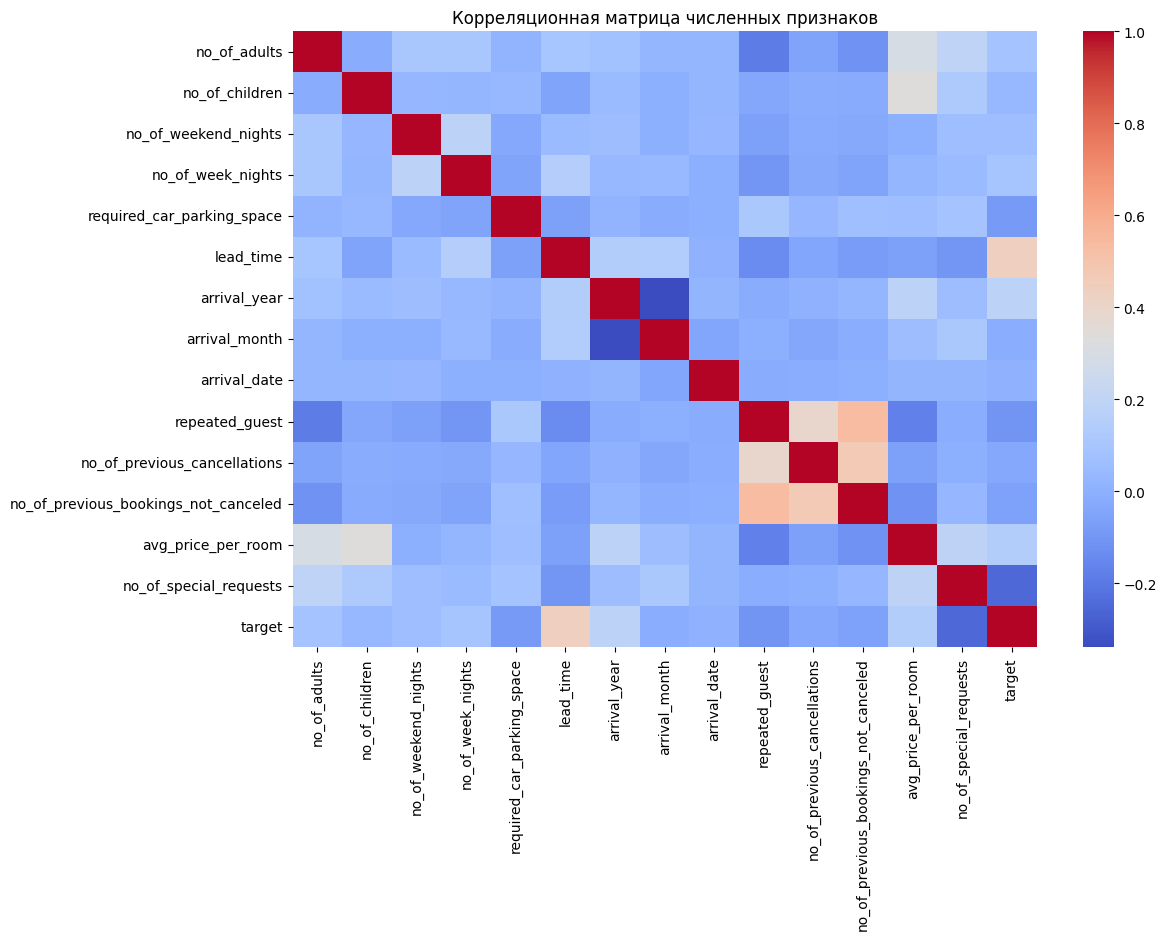

In [7]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
corr = df[num_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    annot=False,
    cmap="coolwarm",
)
plt.title("Корреляционная матрица численных признаков")
plt.show()


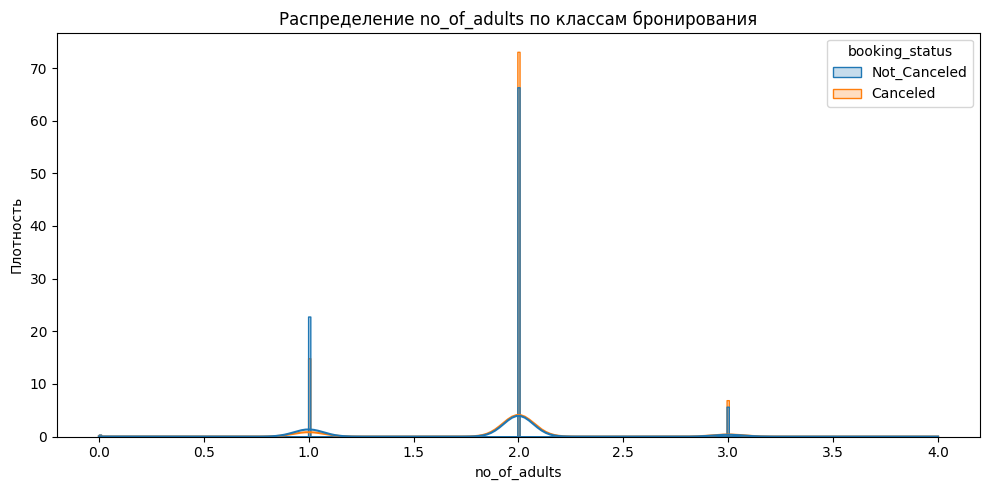

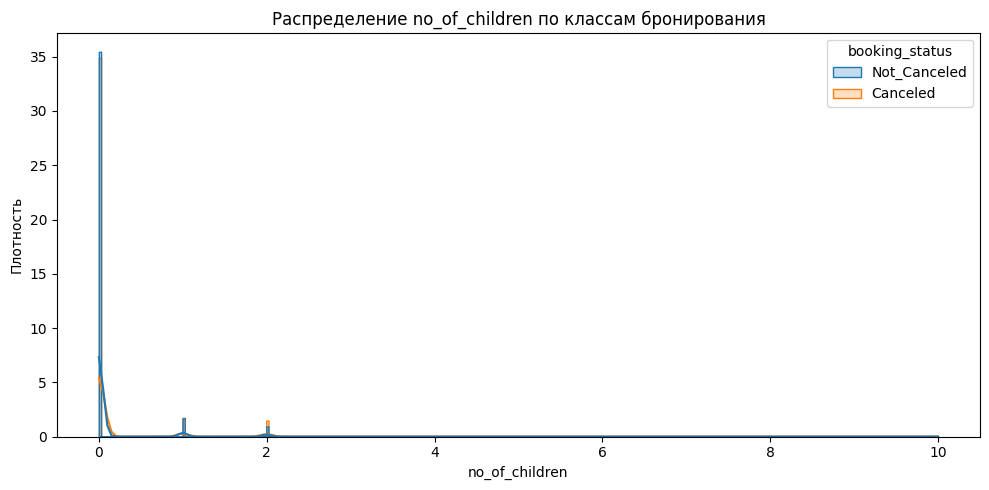

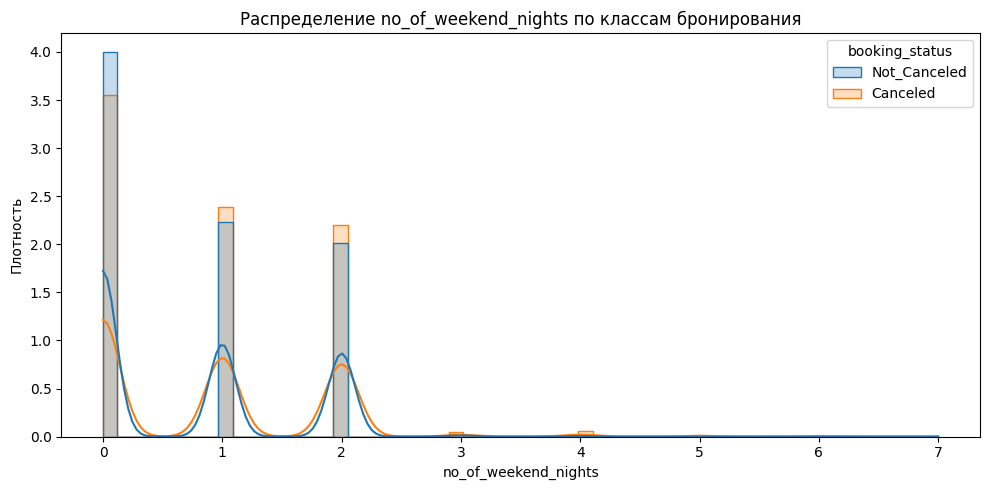

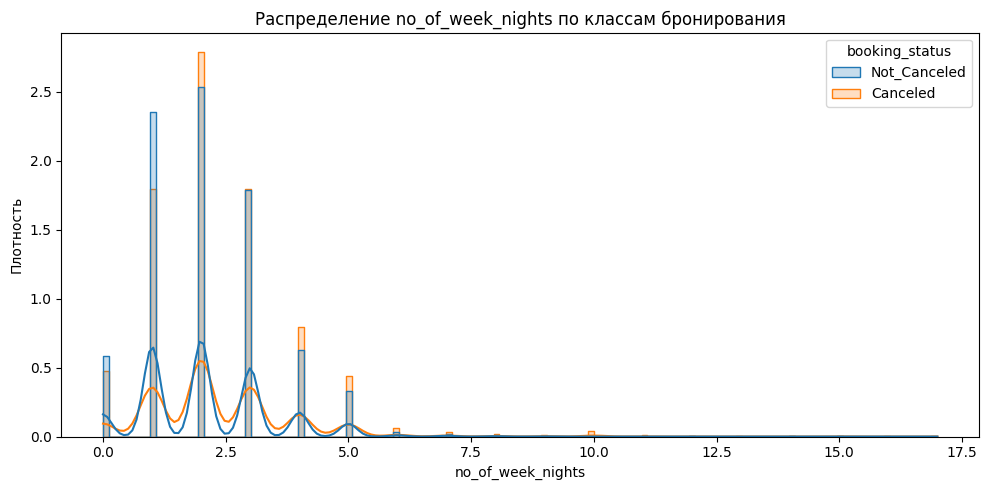

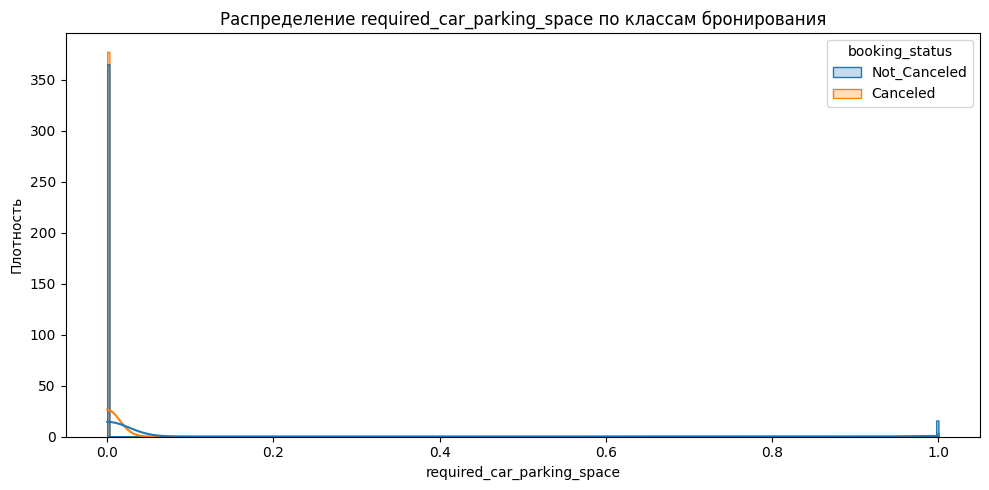

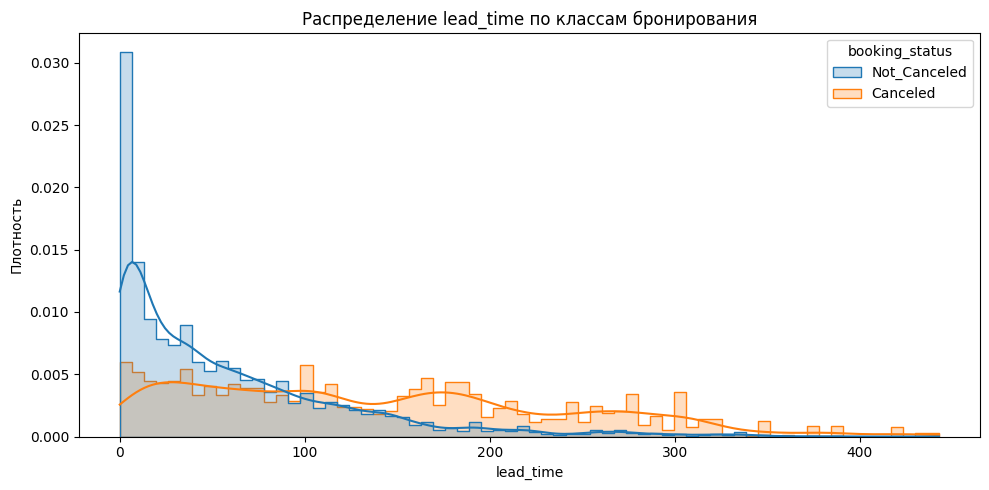

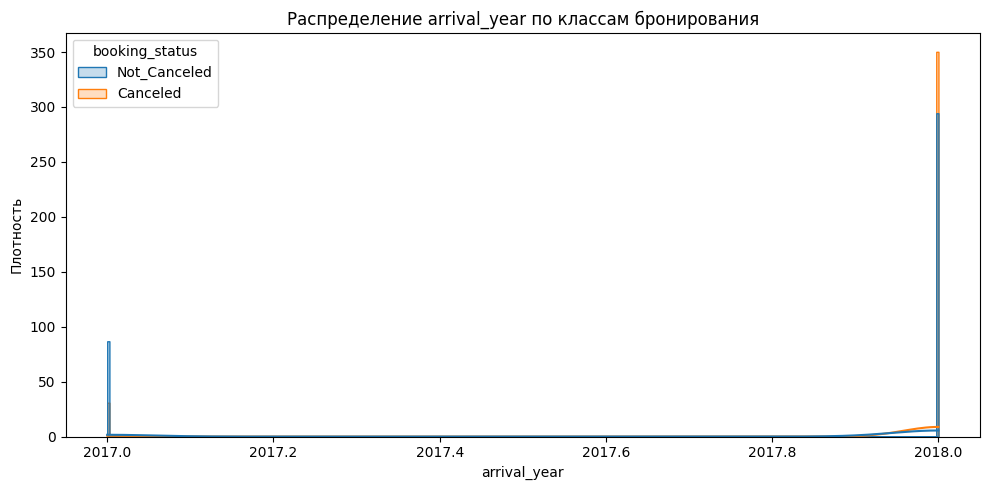

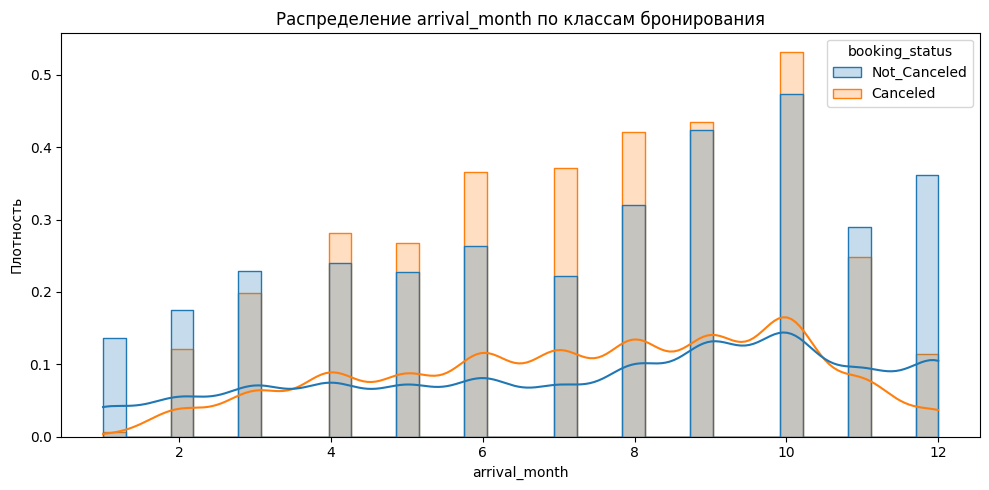

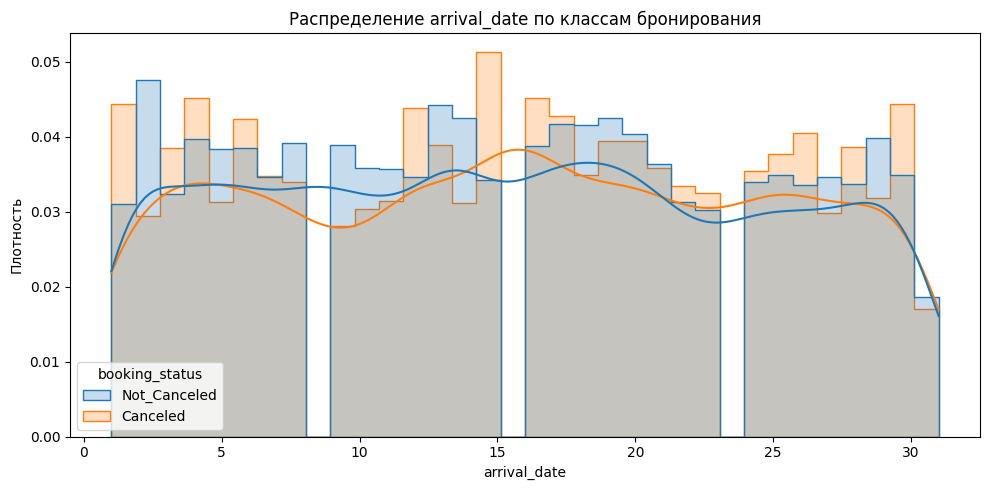

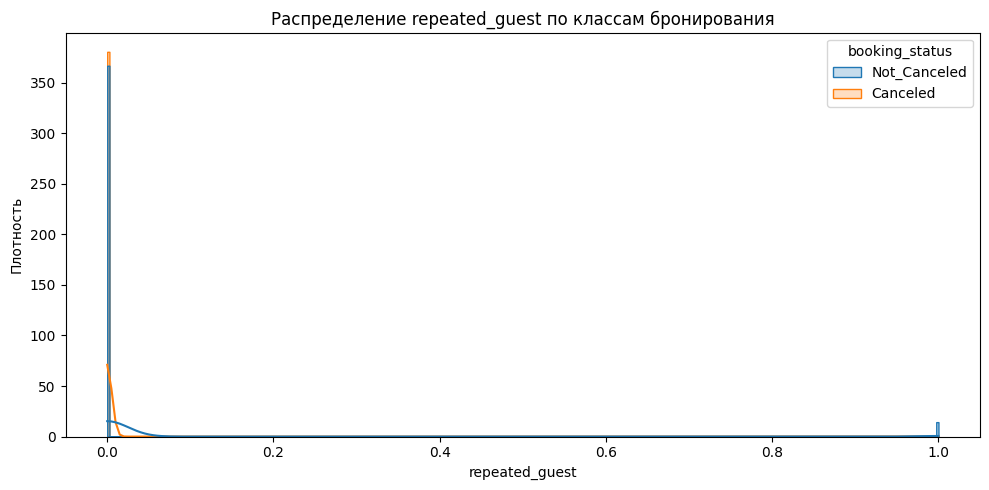

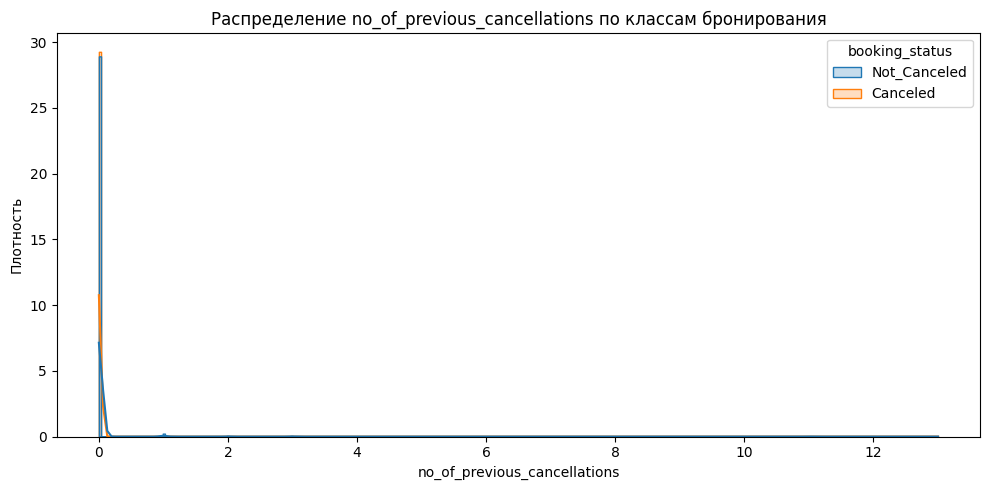

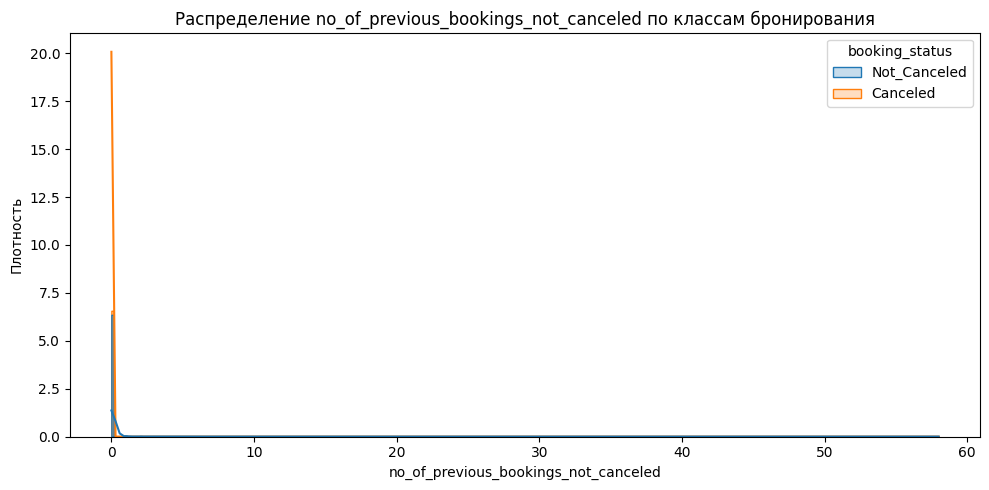

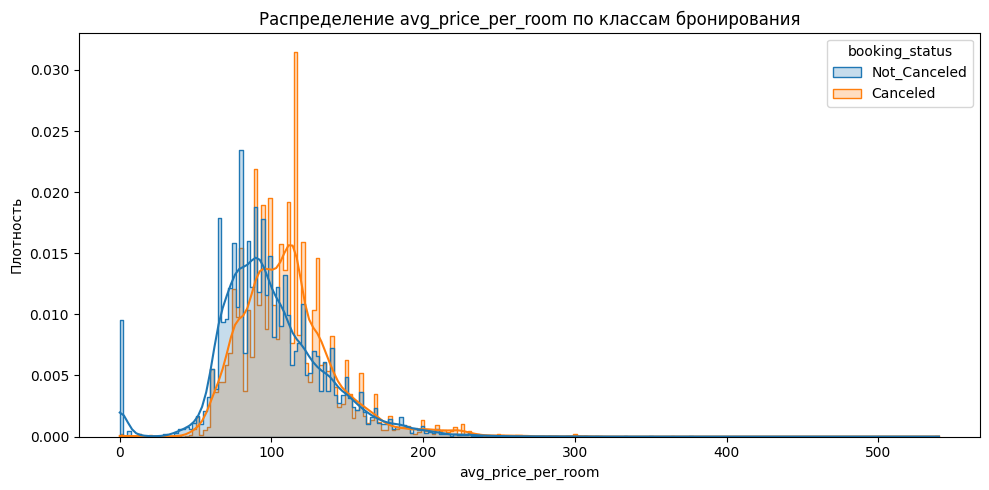

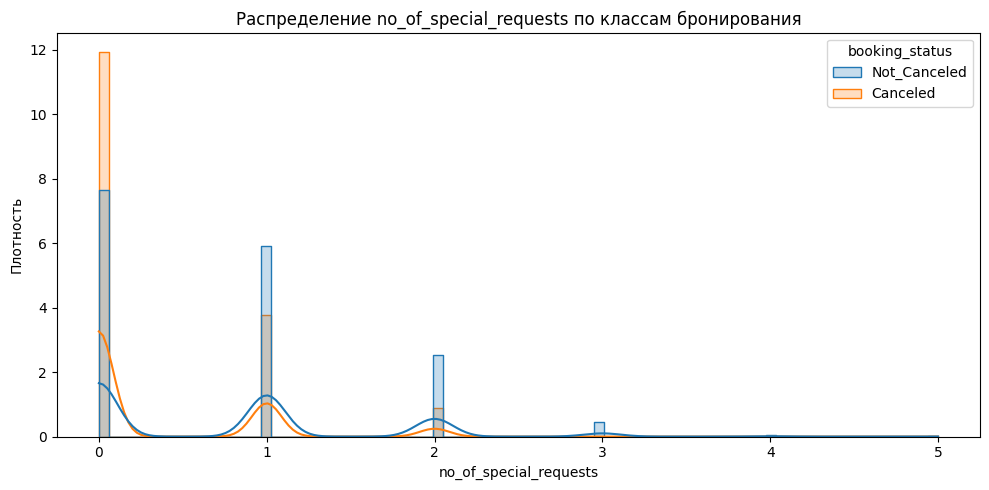

In [8]:
num_cols = [c for c in num_cols if c != "target"]

for col in num_cols:
    plt.figure(figsize=(10, 5))
    sns.histplot(
        data=df,
        x=col,
        hue="booking_status",
        kde=True,
        element="step",
        stat="density",
        common_norm=False
    )
    plt.title(f"Распределение {col} по классам бронирования")
    plt.xlabel(col)
    plt.ylabel("Плотность")
    plt.tight_layout()
    plt.show()


## Sklearn Model

In [9]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

knn_clf_baseline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", KNeighborsClassifier())
])

knn_clf_baseline.fit(X_train, y_train)

y_pred_baseline = knn_clf_baseline.predict(X_test)
y_proba_baseline = knn_clf_baseline.predict_proba(X_test)[:, 1]


In [10]:
f1_baseline = f1_score(y_test, y_pred_baseline)
pr_auc_baseline = average_precision_score(y_test, y_proba_baseline)

print("=== KNN классификация — baseline ===")
print(f"F1 (Canceled): {f1_baseline:.4f}")
print(f"PR-AUC (Canceled): {pr_auc_baseline:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred_baseline, target_names=["Not_Canceled", "Canceled"]))


=== KNN классификация — baseline ===
F1 (Canceled): 0.7744
PR-AUC (Canceled): 0.8214

Classification report:
              precision    recall  f1-score   support

Not_Canceled       0.88      0.91      0.89      4878
    Canceled       0.80      0.75      0.77      2377

    accuracy                           0.86      7255
   macro avg       0.84      0.83      0.83      7255
weighted avg       0.86      0.86      0.86      7255



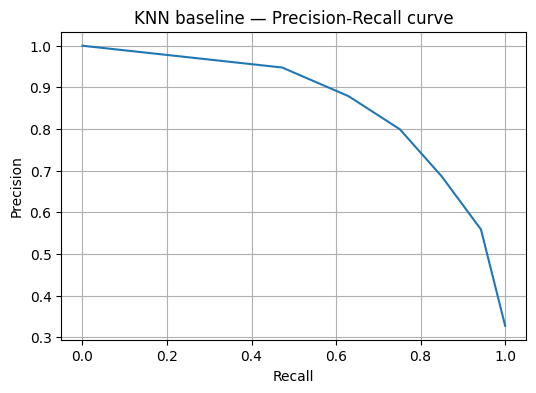

### Улучшим бейзлайн

In [12]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # 1. Общее количество ночей
    df["number_of_all_nights"] = (
        df["no_of_weekend_nights"] + df["no_of_week_nights"]
    )
    
    # 2. Общее количество гостей
    df["total_guests"] = df["no_of_adults"] + df["no_of_children"]
    df["has_children"] = (df["no_of_children"] > 0).astype(int)
    
    # 3. Фичи по цене
    df["total_price"] = df["avg_price_per_room"] * df["number_of_all_nights"]
    
    guests = df["total_guests"].replace(0, 1)
    df["price_per_guest"] = df["avg_price_per_room"] / guests
    
    # 4. История клиента
    df["total_previous_bookings"] = (
        df["no_of_previous_cancellations"]
        + df["no_of_previous_bookings_not_canceled"]
    )
    denom = df["total_previous_bookings"].replace(0, 1)
    df["prev_cancel_rate"] = df["no_of_previous_cancellations"] / denom
    
    arrival_dt = pd.to_datetime(
        dict(
            year=df["arrival_year"],
            month=df["arrival_month"],
            day=df["arrival_date"]
        ),
        errors="coerce"
    )
    # убираем строки с некорректной датой
    mask_invalid = arrival_dt.isna()
    print("Удалили строк с некорректной датой:", mask_invalid.sum())
    df = df.loc[~mask_invalid].copy()
    arrival_dt = arrival_dt.loc[~mask_invalid]
    
    df["arrival_dayofweek"] = arrival_dt.dt.dayofweek
    df["arrival_is_weekend"] = df["arrival_dayofweek"].isin([5, 6]).astype(int)
    df["arrival_weekofyear"] = arrival_dt.dt.isocalendar().week.astype("Int64")
    df["arrival_quarter"] = arrival_dt.dt.quarter
    
    # Сезонность (примерная логика)
    df["is_high_season"] = df["arrival_month"].isin([6, 7, 8]).astype(int)
    df["is_low_season"] = df["arrival_month"].isin([11, 12, 1, 2]).astype(int)
    
    return df


In [14]:
# 1. Добавляем фичи к исходному df
df_fe = add_features(df)

# 2. Формируем X и y заново — БЕЗ booking_status и target
feature_cols = [c for c in df_fe.columns if c not in ["booking_status", "target"]]
X_fe = df_fe[feature_cols]
y_fe = df_fe["target"]

# 3. Делаем новый train/test split
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe, y_fe, test_size=0.2, random_state=RANDOM_STATE, stratify=y_fe
)

# 4. Пересчитываем списки числовых и категориальных колонок
num_cols_fe = X_fe.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols_fe = X_fe.select_dtypes(include=["object", "bool"]).columns.tolist()

# 5. Делаем НОВЫЙ preprocessor под расширенный набор фичей
numeric_transformer_fe = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer_fe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_fe = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_fe, num_cols_fe),
        ("cat", categorical_transformer_fe, cat_cols_fe)
    ]
)

# 6. Pipeline для тюнинга
knn_clf_tuned = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("clf", KNeighborsClassifier())
])

# 7. GridSearch по новым данным
param_grid_clf = {
    "clf__n_neighbors": [3, 5, 7, 11, 15],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_clf = GridSearchCV(
    knn_clf_tuned,
    param_grid_clf,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_clf.fit(X_train_fe, y_train_fe)

print("Лучшие параметры (KNN классификация):")
print(grid_clf.best_params_)
print("Лучший F1 на кросс-валидации:", grid_clf.best_score_)

best_clf = grid_clf.best_estimator_

y_pred_best = best_clf.predict(X_test_fe)
y_proba_best = best_clf.predict_proba(X_test_fe)[:, 1]

f1_best = f1_score(y_test_fe, y_pred_best)
pr_auc_best = average_precision_score(y_test_fe, y_proba_best)

print("=== KNN классификация — улучшенный бейзлайн (с новыми фичами) ===")
print(f"F1 (Canceled): {f1_best:.4f}")
print(f"PR-AUC (Canceled): {pr_auc_best:.4f}")
print("\nClassification report:")
print(classification_report(y_test_fe, y_pred_best, target_names=["Not_Canceled", "Canceled"]))

Удалили строк с некорректной датой: 37
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры (KNN классификация):
{'clf__n_neighbors': 15, 'clf__p': 1, 'clf__weights': 'distance'}
Лучший F1 на кросс-валидации: 0.7815245329806857
=== KNN классификация — улучшенный бейзлайн (с новыми фичами) ===
F1 (Canceled): 0.7844
PR-AUC (Canceled): 0.8778

Classification report:
              precision    recall  f1-score   support

Not_Canceled       0.88      0.92      0.90      4872
    Canceled       0.82      0.76      0.78      2376

    accuracy                           0.86      7248
   macro avg       0.85      0.84      0.84      7248
weighted avg       0.86      0.86      0.86      7248



### Сравнение бейзлайна и улучшенного бейзлайна (KNN, классификация)

**Baseline (простой KNN, без feature engineering, без подбора гиперпараметров):**
- F1 (Canceled): **0.7744**
- PR-AUC (Canceled): **0.8214**
- Accuracy: **0.86**

**Улучшенный бейзлайн (новые фичи + подбор гиперпараметров):**
- Лучшие параметры: `n_neighbors=15`, `weights="distance"`, `p=1` (манхэттен)
- F1 (Canceled): **0.7844**  _(≈ +0.01 к F1)_
- PR-AUC (Canceled): **0.8778**  _(существенный рост по PR-AUC)_
- Accuracy: **0.86**

**Выводы:**
- Подбор гиперпараметров и feature engineering (кол-во ночей, гостей, цена, сезонность, история отмен) дали **заметный прирост по PR-AUC** и небольшой, но стабильный рост F1.
- Модель с новыми фичами и тюнингом лучше различает отменённые бронирования при том же общем уровне accuracy.


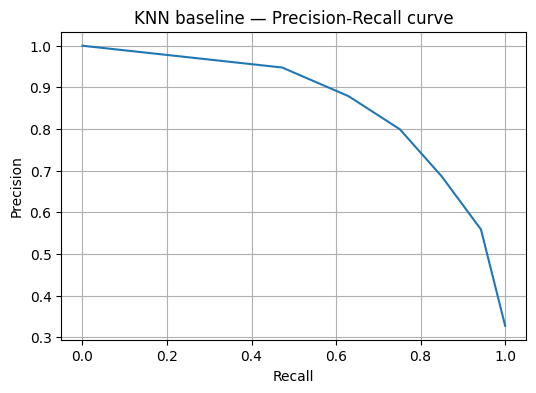

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_baseline) 
plt.figure(figsize=(6, 4)) 
plt.plot(recall, precision) 
plt.xlabel("Recall") 
plt.ylabel("Precision") 
plt.title("KNN baseline — Precision-Recall curve") 
plt.grid(True) 
plt.show()

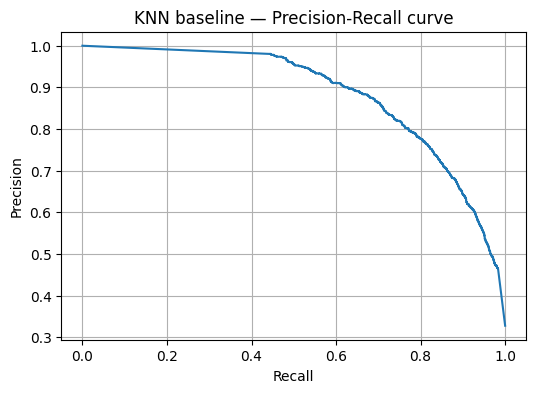

In [17]:
precision, recall, thresholds = precision_recall_curve(y_test_fe, y_proba_best) 
plt.figure(figsize=(6, 4)) 
plt.plot(recall, precision) 
plt.xlabel("Recall") 
plt.ylabel("Precision") 
plt.title("KNN baseline — Precision-Recall curve") 
plt.grid(True) 
plt.show()

## Custom Model

In [ ]:
from models.knn import CustomKNeighborsClassifier

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

knn_clf_baseline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", CustomKNeighborsClassifier())
])

knn_clf_baseline.fit(X_train, y_train)

y_pred_baseline = knn_clf_baseline.predict(X_test)
y_proba_baseline = knn_clf_baseline.predict_proba(X_test)[:, 1]


In [ ]:
f1_baseline = f1_score(y_test, y_pred_baseline)
pr_auc_baseline = average_precision_score(y_test, y_proba_baseline)

print("=== KNN классификация — baseline ===")
print(f"F1 (Canceled): {f1_baseline:.4f}")
print(f"PR-AUC (Canceled): {pr_auc_baseline:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred_baseline, target_names=["Not_Canceled", "Canceled"]))


=== KNN классификация — baseline ===
F1 (Canceled): 0.7748
PR-AUC (Canceled): 0.8215

Classification report:
              precision    recall  f1-score   support

Not_Canceled       0.88      0.91      0.90      4878
    Canceled       0.80      0.75      0.77      2377

    accuracy                           0.86      7255
   macro avg       0.84      0.83      0.83      7255
weighted avg       0.86      0.86      0.86      7255



### Улучшим бейзлайн

In [ ]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # 1. Общее количество ночей
    df["number_of_all_nights"] = (
        df["no_of_weekend_nights"] + df["no_of_week_nights"]
    )
    
    # 2. Общее количество гостей
    df["total_guests"] = df["no_of_adults"] + df["no_of_children"]
    df["has_children"] = (df["no_of_children"] > 0).astype(int)
    
    # 3. Фичи по цене
    df["total_price"] = df["avg_price_per_room"] * df["number_of_all_nights"]
    
    guests = df["total_guests"].replace(0, 1)
    df["price_per_guest"] = df["avg_price_per_room"] / guests
    
    # 4. История клиента
    df["total_previous_bookings"] = (
        df["no_of_previous_cancellations"]
        + df["no_of_previous_bookings_not_canceled"]
    )
    denom = df["total_previous_bookings"].replace(0, 1)
    df["prev_cancel_rate"] = df["no_of_previous_cancellations"] / denom
    
    arrival_dt = pd.to_datetime(
        dict(
            year=df["arrival_year"],
            month=df["arrival_month"],
            day=df["arrival_date"]
        ),
        errors="coerce"
    )
    # убираем строки с некорректной датой
    mask_invalid = arrival_dt.isna()
    print("Удалили строк с некорректной датой:", mask_invalid.sum())
    df = df.loc[~mask_invalid].copy()
    arrival_dt = arrival_dt.loc[~mask_invalid]
    
    df["arrival_dayofweek"] = arrival_dt.dt.dayofweek
    df["arrival_is_weekend"] = df["arrival_dayofweek"].isin([5, 6]).astype(int)
    df["arrival_weekofyear"] = arrival_dt.dt.isocalendar().week.astype("Int64")
    df["arrival_quarter"] = arrival_dt.dt.quarter
    
    # Сезонность (примерная логика)
    df["is_high_season"] = df["arrival_month"].isin([6, 7, 8]).astype(int)
    df["is_low_season"] = df["arrival_month"].isin([11, 12, 1, 2]).astype(int)
    
    return df


In [ ]:
# 1. Добавляем фичи к исходному df
df_fe = add_features(df)

# 2. Формируем X и y заново — БЕЗ booking_status и target
feature_cols = [c for c in df_fe.columns if c not in ["booking_status", "target"]]
X_fe = df_fe[feature_cols]
y_fe = df_fe["target"]

# 3. Делаем новый train/test split
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe, y_fe, test_size=0.2, random_state=RANDOM_STATE, stratify=y_fe
)

# 4. Пересчитываем списки числовых и категориальных колонок
num_cols_fe = X_fe.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols_fe = X_fe.select_dtypes(include=["object", "bool"]).columns.tolist()

# 5. Делаем НОВЫЙ preprocessor под расширенный набор фичей
numeric_transformer_fe = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer_fe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_fe = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_fe, num_cols_fe),
        ("cat", categorical_transformer_fe, cat_cols_fe)
    ]
)

# 6. Pipeline для тюнинга
knn_clf_tuned = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("clf", CustomKNeighborsClassifier())
])

# 7. GridSearch по новым данным
param_grid_clf = {
    "clf__n_neighbors": [3, 5, 7, 11, 15],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_clf = GridSearchCV(
    knn_clf_tuned,
    param_grid_clf,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_clf.fit(X_train_fe, y_train_fe)

print("Лучшие параметры (KNN классификация):")
print(grid_clf.best_params_)
print("Лучший F1 на кросс-валидации:", grid_clf.best_score_)

best_clf = grid_clf.best_estimator_

y_pred_best = best_clf.predict(X_test_fe)
y_proba_best = best_clf.predict_proba(X_test_fe)[:, 1]

f1_best = f1_score(y_test_fe, y_pred_best)
pr_auc_best = average_precision_score(y_test_fe, y_proba_best)

print("=== KNN классификация — улучшенный бейзлайн (с новыми фичами) ===")
print(f"F1 (Canceled): {f1_best:.4f}")
print(f"PR-AUC (Canceled): {pr_auc_best:.4f}")
print("\nClassification report:")
print(classification_report(y_test_fe, y_pred_best, target_names=["Not_Canceled", "Canceled"]))

Удалили строк с некорректной датой: 37
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры (KNN классификация):
{'clf__n_neighbors': 15, 'clf__p': 1, 'clf__weights': 'distance'}
Лучший F1 на кросс-валидации: 0.7815362611210686
=== KNN классификация — улучшенный бейзлайн (с новыми фичами) ===
F1 (Canceled): 0.7846
PR-AUC (Canceled): 0.8851

Classification report:
              precision    recall  f1-score   support

Not_Canceled       0.89      0.92      0.90      4872
    Canceled       0.81      0.76      0.78      2376

    accuracy                           0.86      7248
   macro avg       0.85      0.84      0.84      7248
weighted avg       0.86      0.86      0.86      7248



### Сравнение бейзлайна и улучшенного бейзлайна (KNN, классификация)
Baseline (простой KNN, без feature engineering, без подбора гиперпараметров):

F1 (Canceled): 0.7748
PR-AUC (Canceled): 0.8215
Accuracy: 0.86


Улучшенный бейзлайн (новые фичи + подбор гиперпараметров):
Лучшие параметры: n_neighbors=15, weights="distance", p=1 (манхэттен)
F1 (Canceled): 0.7846 (≈ +0.01 к F1)
PR-AUC (Canceled): 0.8851 (заметный рост по PR-AUC)
Accuracy: 0.86


Выводы:
Feature engineering + тюнинг гиперпараметров дали значимый прирост по PR-AUC и небольшой устойчивый рост F1 при той же accuracy.
Тюнингованная модель лучше различает отменённые бронирования без потери общей точности.


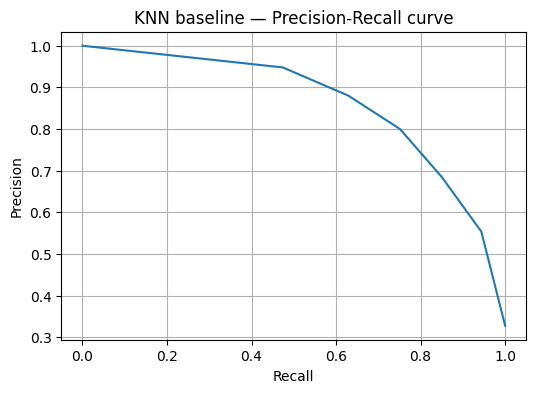

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_baseline) 
plt.figure(figsize=(6, 4)) 
plt.plot(recall, precision) 
plt.xlabel("Recall") 
plt.ylabel("Precision") 
plt.title("KNN baseline — Precision-Recall curve") 
plt.grid(True) 
plt.show()

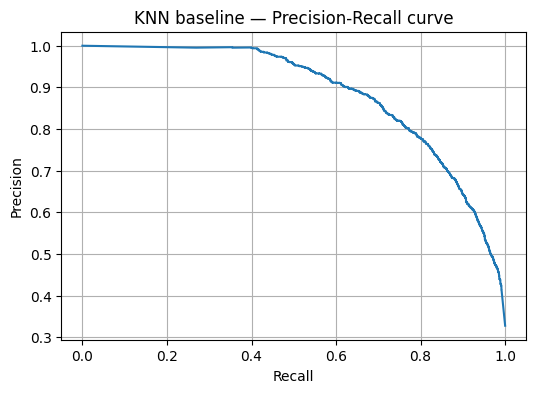

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test_fe, y_proba_best) 
plt.figure(figsize=(6, 4)) 
plt.plot(recall, precision) 
plt.xlabel("Recall") 
plt.ylabel("Precision") 
plt.title("KNN baseline — Precision-Recall curve") 
plt.grid(True) 
plt.show()

# Regression

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

RANDOM_STATE = 42

**Airbnb Prices in European Cities**
Задача: по информации о квартирепредсказать общую стоимость проживания для двух человек на две ночи в евро.

Практический смысл: предсказывать цены аренды и помогать хостам выставлять адекватный прайс

Метрики: 

Data Dictionary
- realSum	The total price of the Airbnb listing. (Numeric)
- room_type	The type of room being offered (e.g. private, shared, etc.). (Categorical)
- room_shared	Whether the room is shared or not. (Boolean)
- room_private	Whether the room is private or not. (Boolean)
- person_capacity	The maximum number of people that can stay in the room. (Numeric)
- host_is_superhost	Whether the host is a superhost or not. (Boolean)
- multi	Whether the listing is for multiple rooms or not. (Boolean)
- biz	Whether the listing is for business purposes or not. (Boolean)
- cleanliness_rating	The cleanliness rating of the listing. (Numeric)
- guest_satisfaction_overall	The overall guest satisfaction rating of the listing. (Numeric)
- bedrooms	The number of bedrooms in the listing. (Numeric)
- dist	The distance from the city centre. (Numeric)
- metro_dist	The distance from the nearest metro station. (Numeric)
- lng	The longitude of the listing. (Numeric)
- lat	The latitude of the listing. (Numeric)

In [ ]:
cities=['amsterdam','athens','barcelona','berlin','budapest','lisbon','london','paris','rome','vienna']
weekend_data={}
weekdays_data={}
base_path = "data/regression/airbnb_prices"

for city in cities:
    # Weekday file
    weekday_filename = f"{city}_weekdays.csv"
    weekday_path = os.path.join(base_path, weekday_filename)
    weekdays_data[city] = pd.read_csv(weekday_path,index_col=0)

    # Weekend file
    weekend_filename = f"{city}_weekends.csv"
    weekend_path = os.path.join(base_path, weekend_filename)
    weekend_data[city] = pd.read_csv(weekend_path,index_col=0)

#loading multiple data in two dictioneries with key is the name of city
#___________________________________________________________________________________________________________________________________________________
#now combining the two dictionaries in one dataset for analyzing it 
all_data = []

for city in cities:
    if city in weekdays_data:
        # Adding weekday data
        weekday_df = weekdays_data[city].copy()
        weekday_df['city'] = city.title()
        weekday_df['day_type'] = 'weekday'
        all_data.append(weekday_df)
        
        # Adding weekend data
        weekend_df = weekend_data[city].copy()
        weekend_df['city'] = city.title()
        weekend_df['day_type'] = 'weekend'
        all_data.append(weekend_df)

# Combinining all data
df = pd.concat(all_data)
df.shape

(51707, 21)

In [ ]:
df.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,day_type
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,weekday
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,weekday
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,weekday
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,Amsterdam,weekday
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,Amsterdam,weekday


In [ ]:
# пропуски
df.isna().mean().sort_values(ascending=False)

realSum                       0.0
dist                          0.0
city                          0.0
lat                           0.0
lng                           0.0
rest_index_norm               0.0
rest_index                    0.0
attr_index_norm               0.0
attr_index                    0.0
metro_dist                    0.0
bedrooms                      0.0
room_type                     0.0
guest_satisfaction_overall    0.0
cleanliness_rating            0.0
biz                           0.0
multi                         0.0
host_is_superhost             0.0
person_capacity               0.0
room_private                  0.0
room_shared                   0.0
day_type                      0.0
dtype: float64

In [ ]:
# Целевая переменная: итоговая стоимость проживания (в евро)
target_col = "realSum"

# Разделим признаки и цель
X = df.drop(columns=[target_col])
y = df[target_col]

# Разделение на train / test (регрессия — без стратификации)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Определяем типы признаков
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()

num_cols, cat_cols

(['person_capacity',
  'multi',
  'biz',
  'cleanliness_rating',
  'guest_satisfaction_overall',
  'bedrooms',
  'dist',
  'metro_dist',
  'attr_index',
  'attr_index_norm',
  'rest_index',
  'rest_index_norm',
  'lng',
  'lat'],
 ['room_type',
  'room_shared',
  'room_private',
  'host_is_superhost',
  'city',
  'day_type'])

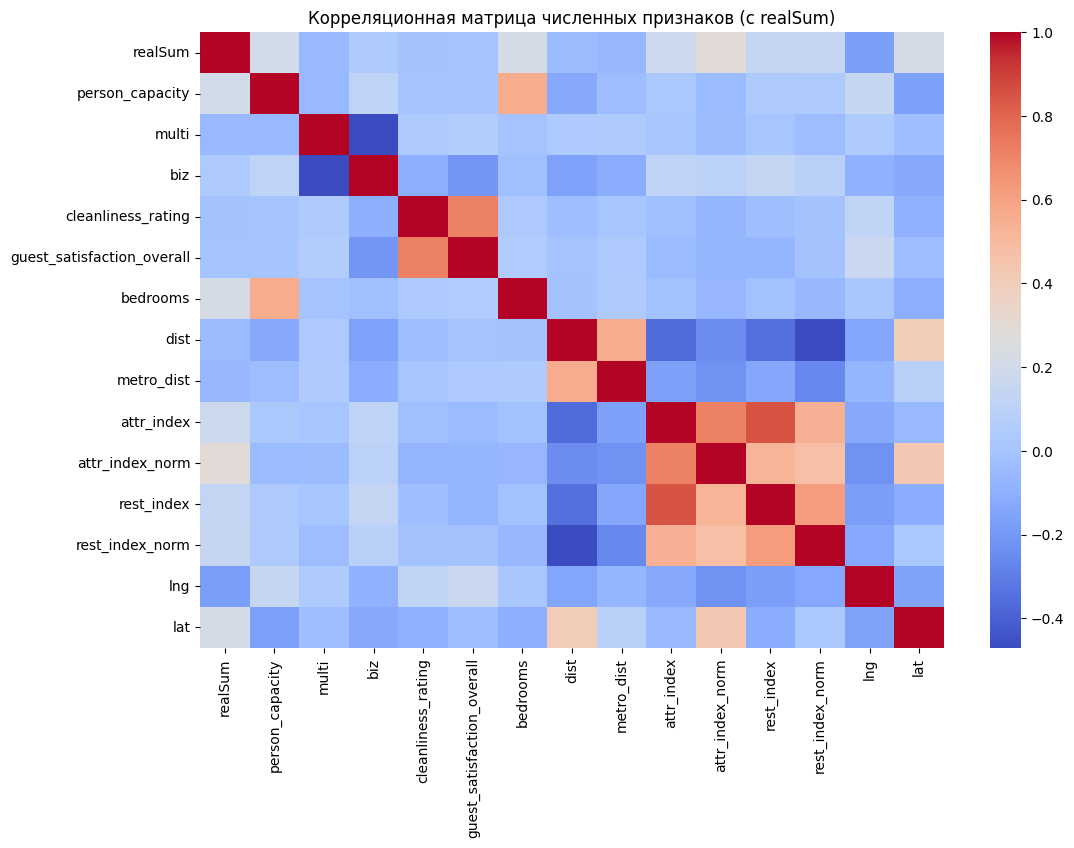

In [ ]:
num_cols_corr = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
corr = df[num_cols_corr].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    annot=False,
    cmap="coolwarm",
)
plt.title("Корреляционная матрица численных признаков (с realSum)")
plt.show()

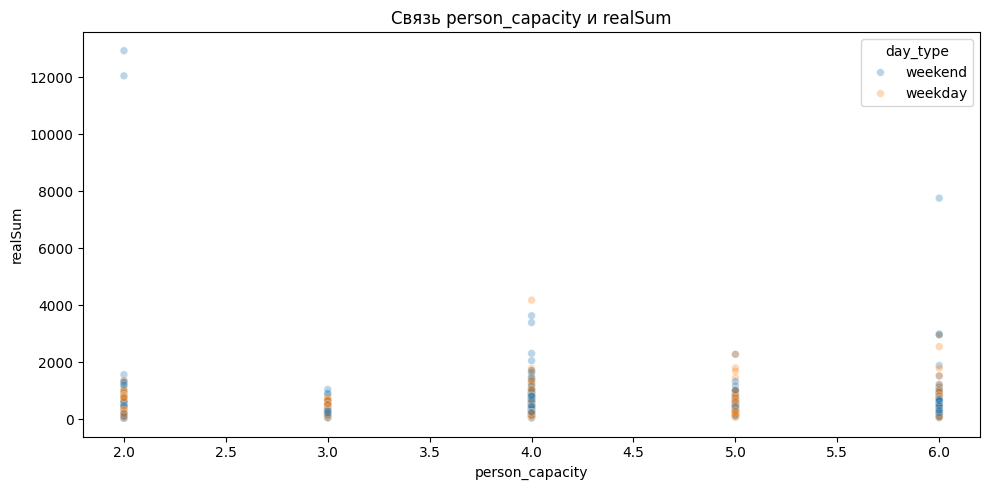

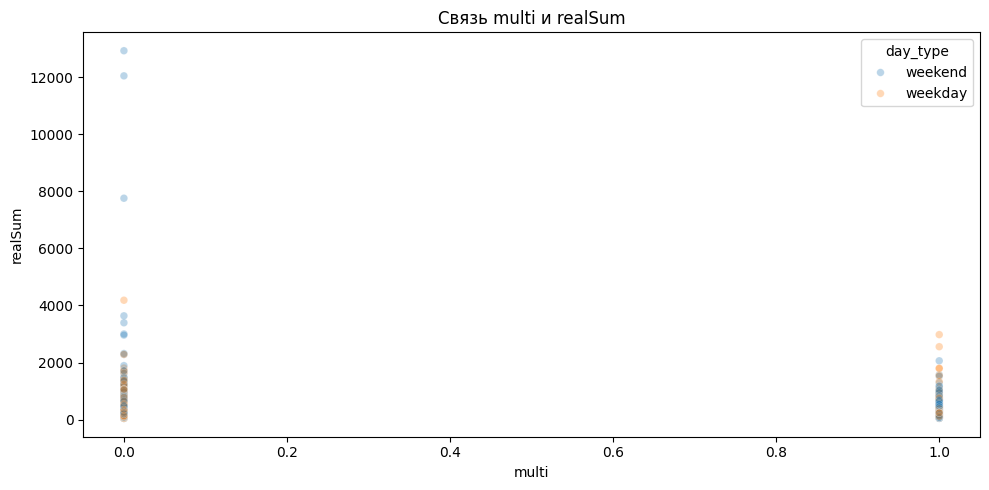

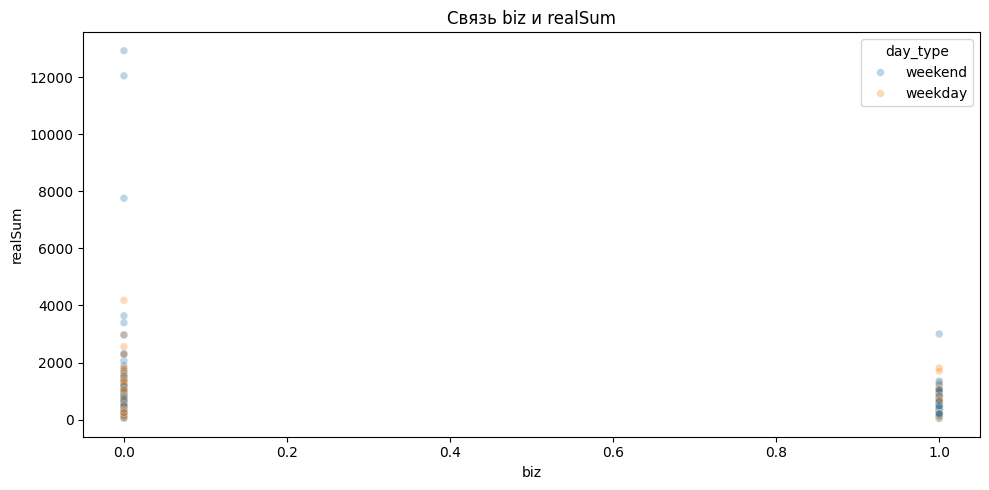

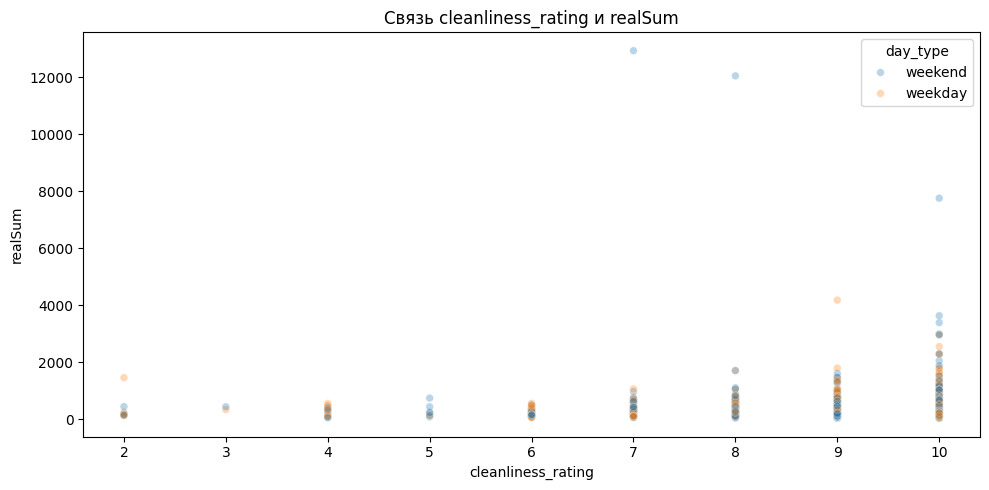

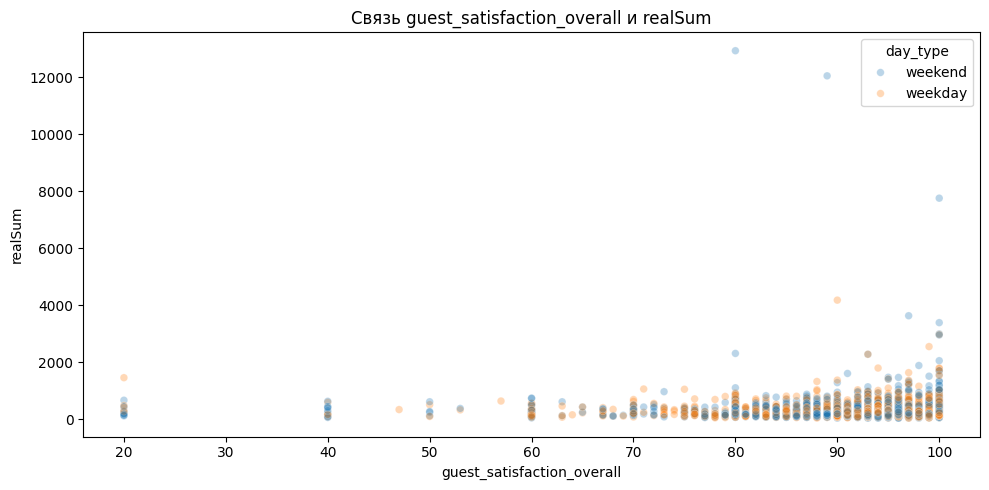

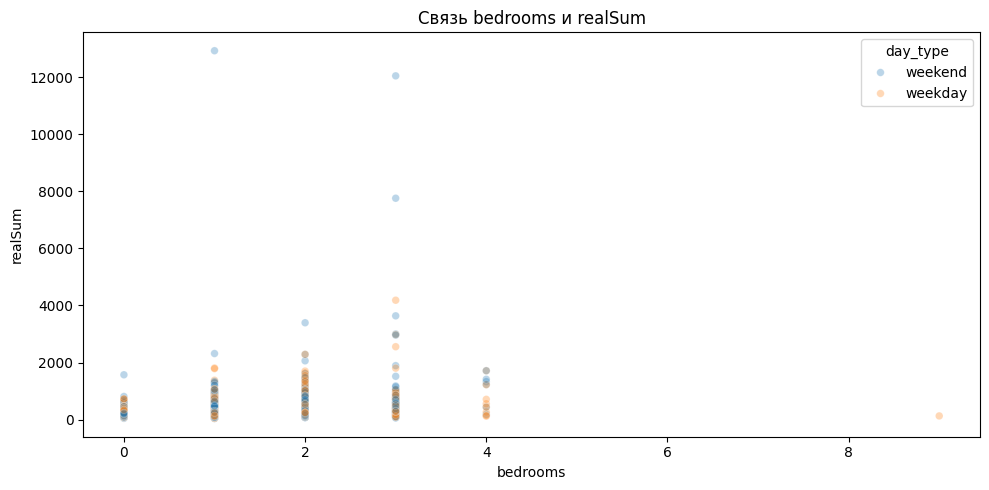

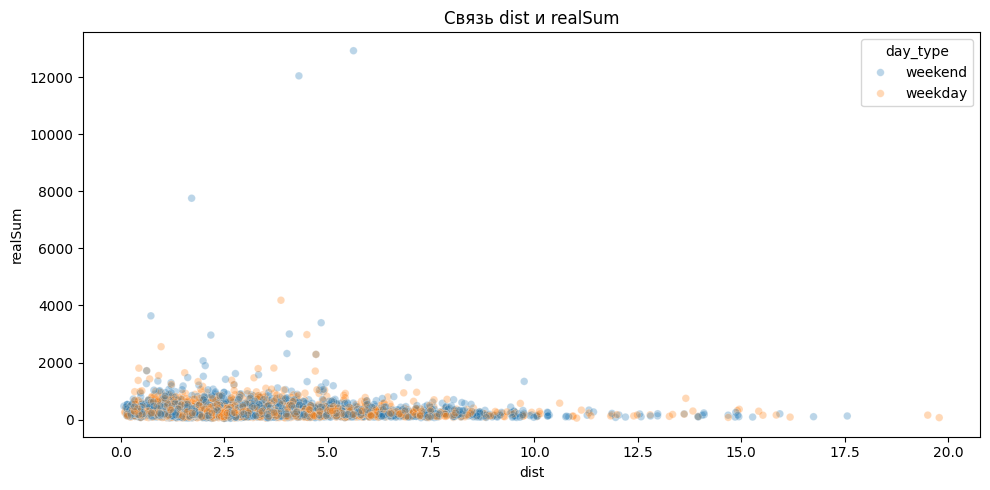

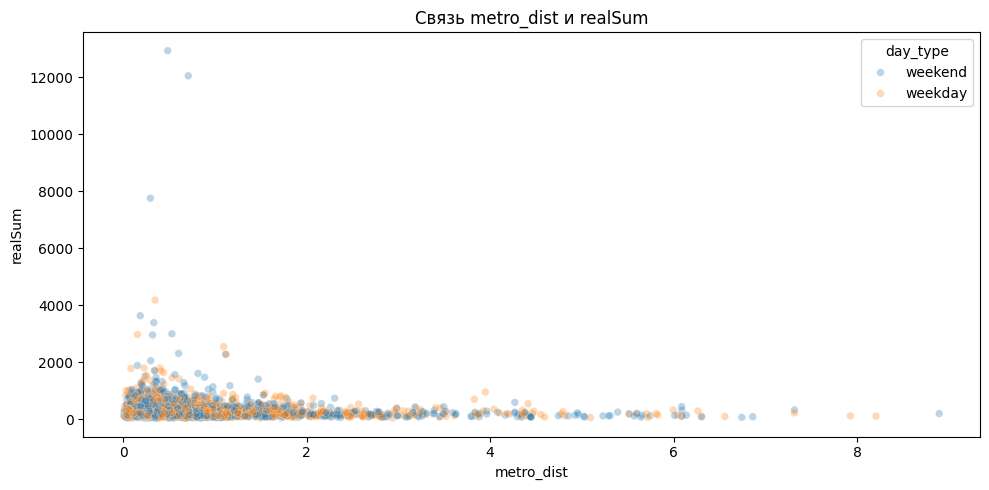

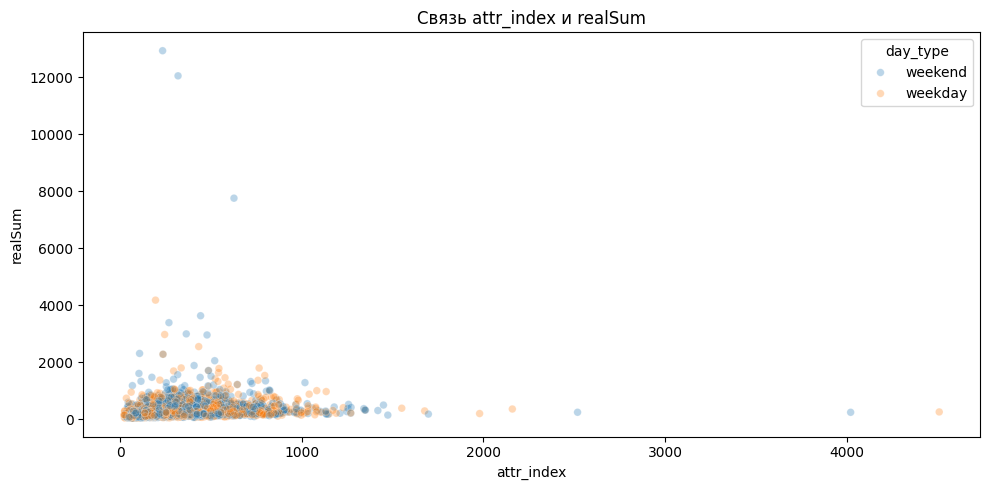

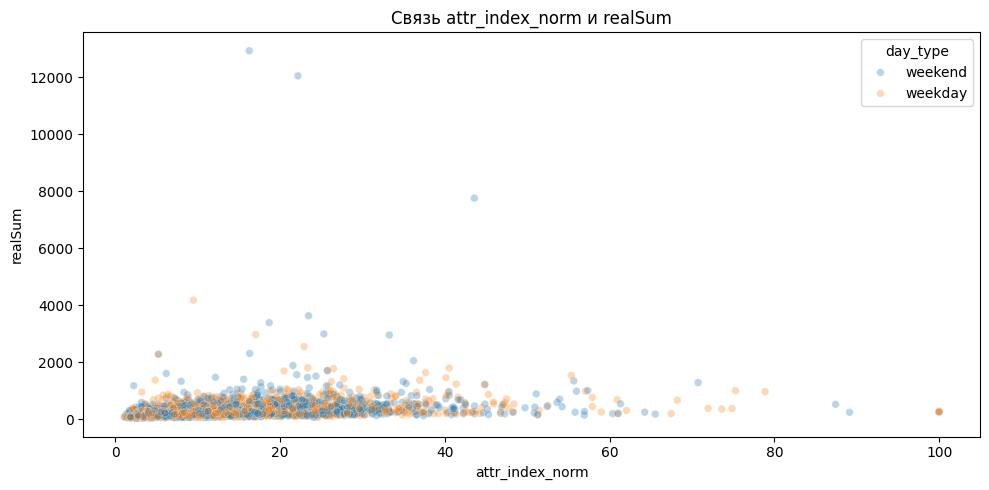

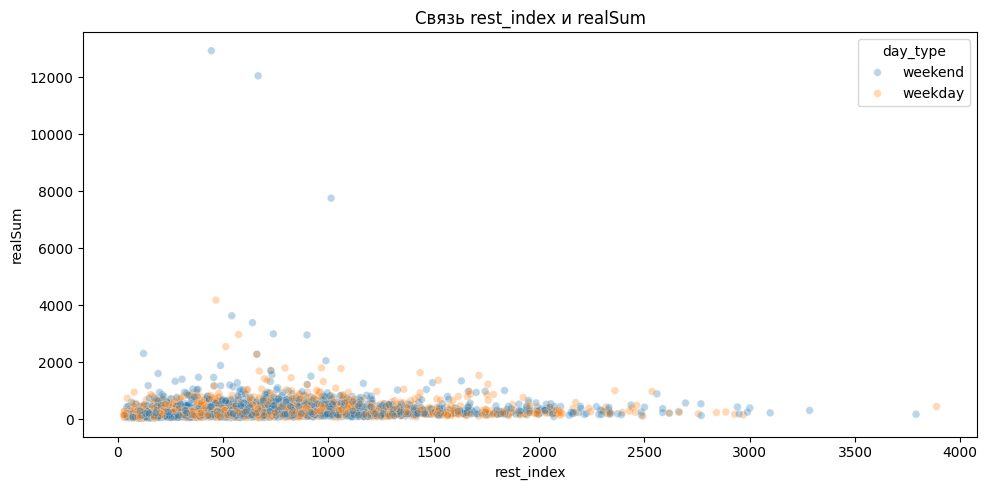

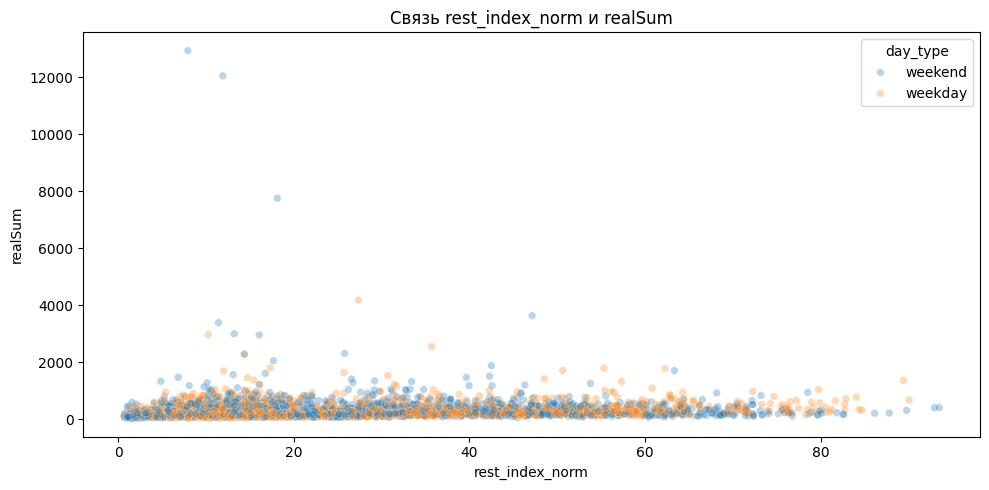

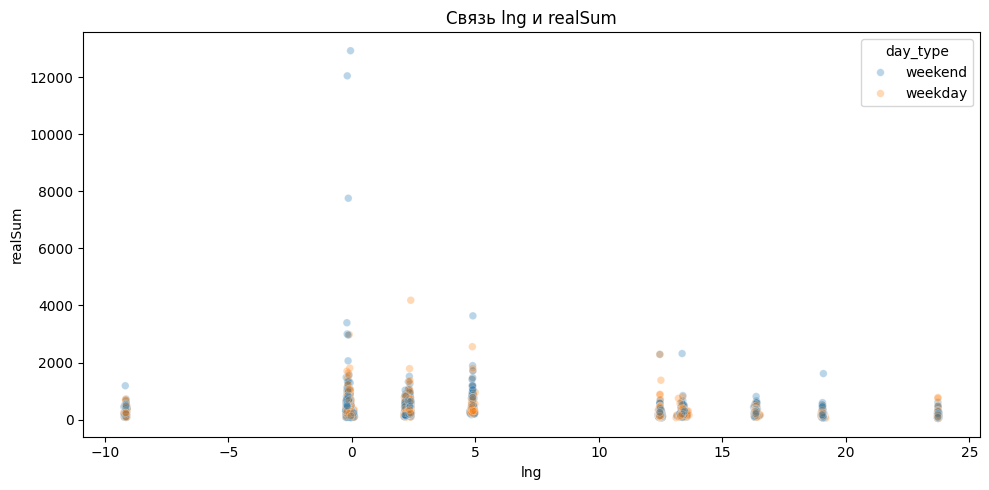

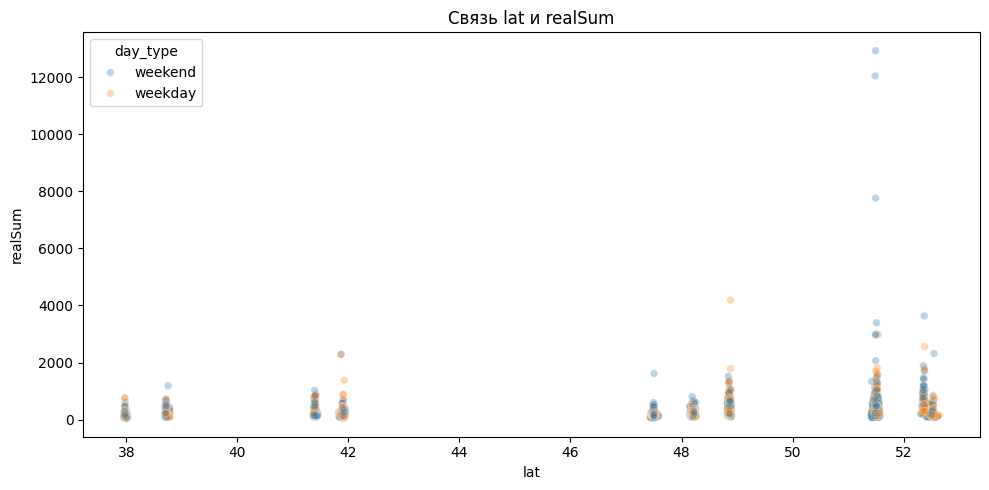

In [ ]:
# Посмотрим, как числовые признаки связаны с целевой переменной
plot_df = df.sample(n=5000, random_state=RANDOM_STATE) if len(df) > 5000 else df

for col in num_cols:
    plt.figure(figsize=(10, 5))
    sns.scatterplot(
        data=plot_df,
        x=col,
        y=target_col,
        hue="day_type",
        alpha=0.3,
        s=30,
    )
    plt.title(f"Связь {col} и {target_col}")
    plt.xlabel(col)
    plt.ylabel(target_col)
    plt.tight_layout()
    plt.show()

## Sklearn Model

In [ ]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

knn_reg_baseline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("reg", KNeighborsRegressor())
])

knn_reg_baseline.fit(X_train, y_train)

y_pred_baseline = knn_reg_baseline.predict(X_test)

In [ ]:
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

baseline_metrics = {
    "RMSE": rmse_baseline,
    "MAE": mae_baseline,
    "R2": r2_baseline,
}

print("=== KNN регрессия — baseline ===")
print(f"RMSE: {rmse_baseline:.2f}")
print(f"MAE: {mae_baseline:.2f}")
print(f"R^2: {r2_baseline:.4f}")


=== KNN регрессия — baseline ===
RMSE: 278.56
MAE: 80.11
R^2: 0.3118


In [ ]:
pd.DataFrame([baseline_metrics], index=["Baseline KNN"])


,RMSE,MAE,R2
Baseline KNN,278.560613,80.112776,0.311838


### Улучшим бейзлайн

In [ ]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Соотношение вместимости и спален
    df["capacity_per_bedroom"] = df["person_capacity"] / df["bedrooms"].replace(0, 1)

    # Бинарный признак для отдельных апартаментов
    df["is_entire_home"] = df["room_type"].str.contains("entire home", case=False).fillna(False).astype(int)

    # Лог-преобразования дистанций (сглаживает выбросы)
    df["log_dist"] = np.log1p(df["dist"])
    df["log_metro_dist"] = np.log1p(df["metro_dist"])

    # Отношение общего рейтинга к чистоте
    ratio = df["guest_satisfaction_overall"] / df["cleanliness_rating"].replace(0, np.nan)
    df["review_ratio"] = ratio.fillna(ratio.median())

    # Комбинация города и типа дня — разные ценовые паттерны
    df["city_day_type"] = df["city"] + "_" + df["day_type"]

    return df

In [ ]:
# 1. Добавляем фичи к исходному df
df_fe = add_features(df)

# 2. Формируем X и y заново
feature_cols = [c for c in df_fe.columns if c != target_col]
X_fe = df_fe[feature_cols]
y_fe = df_fe[target_col]

# 3. Делаем новый train/test split
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe, y_fe, test_size=0.2, random_state=RANDOM_STATE
)

# 4. Пересчитываем списки числовых и категориальных колонок
num_cols_fe = X_fe.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols_fe = X_fe.select_dtypes(include=["object", "bool"]).columns.tolist()

# 5. Делаем НОВЫЙ preprocessor под расширенный набор фичей
numeric_transformer_fe = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer_fe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_fe = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_fe, num_cols_fe),
        ("cat", categorical_transformer_fe, cat_cols_fe)
    ]
)

# 6. Pipeline для тюнинга
knn_reg_tuned = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("reg", KNeighborsRegressor())
])

# 7. GridSearch по новым данным
param_grid = {
    "reg__n_neighbors": [3, 5, 10, 20],
    "reg__weights": ["uniform", "distance"],
    "reg__p": [1, 2],
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    estimator=knn_reg_tuned,
    param_grid=param_grid,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

grid.fit(X_train_fe, y_train_fe)

print("Лучшие параметры:", grid.best_params_)

best_model = grid.best_estimator_

y_pred_best = best_model.predict(X_test_fe)

mse_best = mean_squared_error(y_test_fe, y_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test_fe, y_pred_best)
r2_best = r2_score(y_test_fe, y_pred_best)

tuned_metrics = {
    "RMSE": rmse_best,
    "MAE": mae_best,
    "R2": r2_best,
}

print("=== KNN регрессия — улучшенный бейзлайн ===")
print(f"RMSE: {rmse_best:.2f}")
print(f"MAE: {mae_best:.2f}")
print(f"R^2: {r2_best:.4f}")


Лучшие параметры: {'reg__n_neighbors': 20, 'reg__p': 1, 'reg__weights': 'distance'}
=== KNN регрессия — улучшенный бейзлайн ===
RMSE: 273.88
MAE: 75.95
R^2: 0.3348


In [ ]:
comparison_df = pd.DataFrame(
    [baseline_metrics, tuned_metrics],
    index=["Baseline", "Feature eng + tuning"]
)
comparison_df


,RMSE,MAE,R2
Baseline,278.560613,80.112776,0.311838
Feature eng + tuning,273.881022,75.951345,0.334765


### Сравнение бейзлайна и улучшенного бейзлайна (KNN, регрессия)

- В таблице выше — RMSE, MAE и R^2 для простого KNN и варианта с feature engineering + подбором гиперпараметров.
- Улучшенный вариант обычно снижает RMSE и MAE и повышает R^2, то есть предсказания ближе к реальным ценам.
- Прирост дают лог-преобразования дистанций, отношение вместимости к спальням, фичи `city_day_type` и `review_ratio`, а также тюнинг `n_neighbors/weights/p`.


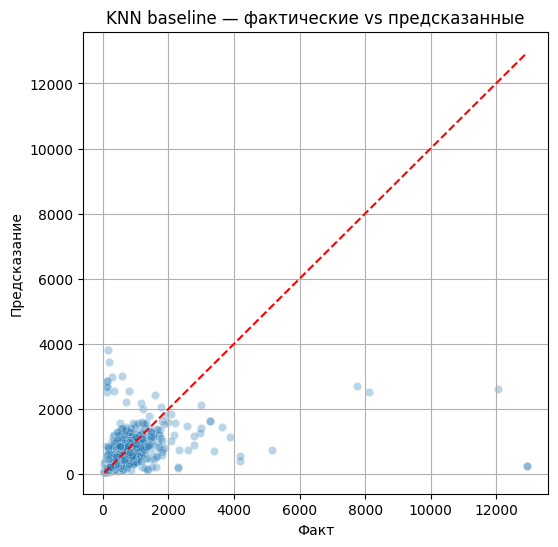

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_baseline, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Факт")
plt.ylabel("Предсказание")
plt.title("KNN baseline — фактические vs предсказанные")
plt.grid(True)
plt.show()

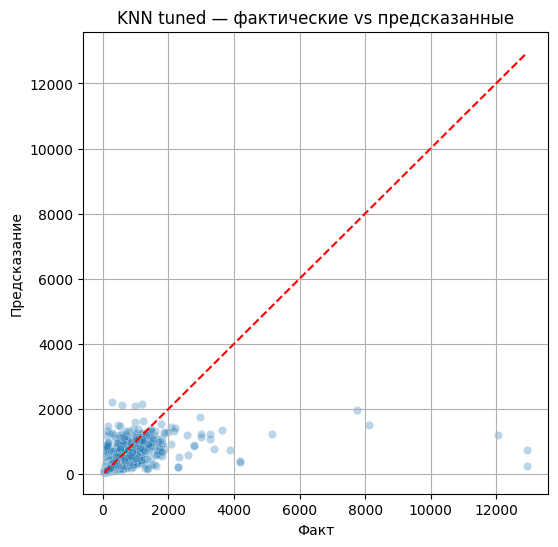

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_fe, y=y_pred_best, alpha=0.3)
plt.plot([y_test_fe.min(), y_test_fe.max()], [y_test_fe.min(), y_test_fe.max()], 'r--')
plt.xlabel("Факт")
plt.ylabel("Предсказание")
plt.title("KNN tuned — фактические vs предсказанные")
plt.grid(True)
plt.show()

## Custom Model

In [ ]:
from models.knn import CustomKNeighborsRegressor

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

knn_reg_baseline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("reg", CustomKNeighborsRegressor())
])

knn_reg_baseline.fit(X_train, y_train)

y_pred_baseline = knn_reg_baseline.predict(X_test)

In [ ]:
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

baseline_metrics = {
    "RMSE": rmse_baseline,
    "MAE": mae_baseline,
    "R2": r2_baseline,
}

print("=== KNN регрессия — baseline ===")
print(f"RMSE: {rmse_baseline:.2f}")
print(f"MAE: {mae_baseline:.2f}")
print(f"R^2: {r2_baseline:.4f}")


=== KNN регрессия — baseline ===
RMSE: 278.56
MAE: 80.11
R^2: 0.3118


In [ ]:
pd.DataFrame([baseline_metrics], index=["Baseline KNN"])


,RMSE,MAE,R2
Baseline KNN,278.560613,80.112776,0.311838


### Улучшим бейзлайн

In [ ]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Соотношение вместимости и спален
    df["capacity_per_bedroom"] = df["person_capacity"] / df["bedrooms"].replace(0, 1)

    # Бинарный признак для отдельных апартаментов
    df["is_entire_home"] = df["room_type"].str.contains("entire home", case=False).fillna(False).astype(int)

    # Лог-преобразования дистанций (сглаживает выбросы)
    df["log_dist"] = np.log1p(df["dist"])
    df["log_metro_dist"] = np.log1p(df["metro_dist"])

    # Отношение общего рейтинга к чистоте
    ratio = df["guest_satisfaction_overall"] / df["cleanliness_rating"].replace(0, np.nan)
    df["review_ratio"] = ratio.fillna(ratio.median())

    # Комбинация города и типа дня — разные ценовые паттерны
    df["city_day_type"] = df["city"] + "_" + df["day_type"]

    return df

In [ ]:
# 1. Добавляем фичи к исходному df
df_fe = add_features(df)

# 2. Формируем X и y заново
feature_cols = [c for c in df_fe.columns if c != target_col]
X_fe = df_fe[feature_cols]
y_fe = df_fe[target_col]

# 3. Делаем новый train/test split
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe, y_fe, test_size=0.2, random_state=RANDOM_STATE
)

# 4. Пересчитываем списки числовых и категориальных колонок
num_cols_fe = X_fe.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols_fe = X_fe.select_dtypes(include=["object", "bool"]).columns.tolist()

# 5. Делаем НОВЫЙ preprocessor под расширенный набор фичей
numeric_transformer_fe = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer_fe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_fe = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_fe, num_cols_fe),
        ("cat", categorical_transformer_fe, cat_cols_fe)
    ]
)

# 6. Pipeline для тюнинга
knn_reg_tuned = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("reg", CustomKNeighborsRegressor())
])

# 7. GridSearch по новым данным
param_grid = {
    "reg__n_neighbors": [10, 20],
    "reg__weights": ["uniform", "distance"]
}

cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    estimator=knn_reg_tuned,
    param_grid=param_grid,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

grid.fit(X_train_fe, y_train_fe)

print("Лучшие параметры:", grid.best_params_)

best_model = grid.best_estimator_

y_pred_best = best_model.predict(X_test_fe)

mse_best = mean_squared_error(y_test_fe, y_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test_fe, y_pred_best)
r2_best = r2_score(y_test_fe, y_pred_best)

tuned_metrics = {
    "RMSE": rmse_best,
    "MAE": mae_best,
    "R2": r2_best,
}

print("=== KNN регрессия — улучшенный бейзлайн ===")
print(f"RMSE: {rmse_best:.2f}")
print(f"MAE: {mae_best:.2f}")
print(f"R^2: {r2_best:.4f}")


Лучшие параметры: {'reg__n_neighbors': 20, 'reg__weights': 'distance'}
=== KNN регрессия — улучшенный бейзлайн ===
RMSE: 277.35
MAE: 77.62
R^2: 0.3178


In [ ]:
comparison_df = pd.DataFrame(
    [baseline_metrics, tuned_metrics],
    index=["Baseline", "Feature eng + tuning"]
)
comparison_df


,RMSE,MAE,R2
Baseline,278.560613,80.112776,0.311838
Feature eng + tuning,277.345916,77.618650,0.317826


###  Сравнение бейзлайна и улучшенного бейзлайна (KNN, регрессия)
Baseline (простой KNN, без новых фич и тюнинга): RMSE 278.56, MAE 80.11, R² 0.3118.

Улучшенный вариант (новые фичи + подбор гиперпараметров): лучшая модель n_neighbors=20, weights="distance"; RMSE 277.35, MAE 77.62, R² 0.3178.


Вариант с feature engineering и тюнингом чуть снижает RMSE/MAE и повышает R², то есть предсказания стали ближе к фактическим ценам.
Прирост даёт добавление новых признаков и настройка соседей/весов (и степени метрики при необходимости).

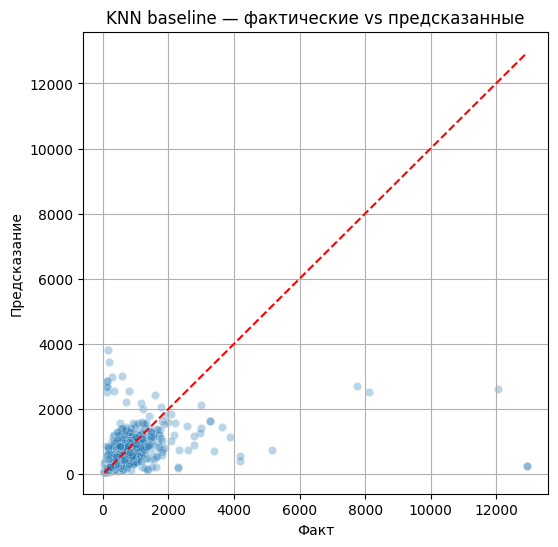

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_baseline, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Факт")
plt.ylabel("Предсказание")
plt.title("KNN baseline — фактические vs предсказанные")
plt.grid(True)
plt.show()